# Import libraries

In [1]:
import sys
sys.path.append('../')

In [23]:
from libraries.dataManipulation import *
from libraries.gridManipulation import *
from data_preparator import *
import numpy as np
from collections import Counter
import csv

# Create and plot grid

In [3]:
#GRID CONFIGURATION IS DECLARED
o_x = 5000
o_y = -10000
o = (o_x,o_y)

#TOTAL GRID SHOULD BE SIZE 67000x13000
patch_width = 1000
patch_height = 1000
patch_size = (patch_width, patch_height)

total_patches = (67,14)
abs_total_patches = total_patches[0]*total_patches[1]

grid_angle = 0

trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/background_images/EHV.Perron2.1_multisensor.png
background fetched. Accessible as <this-object>.bg


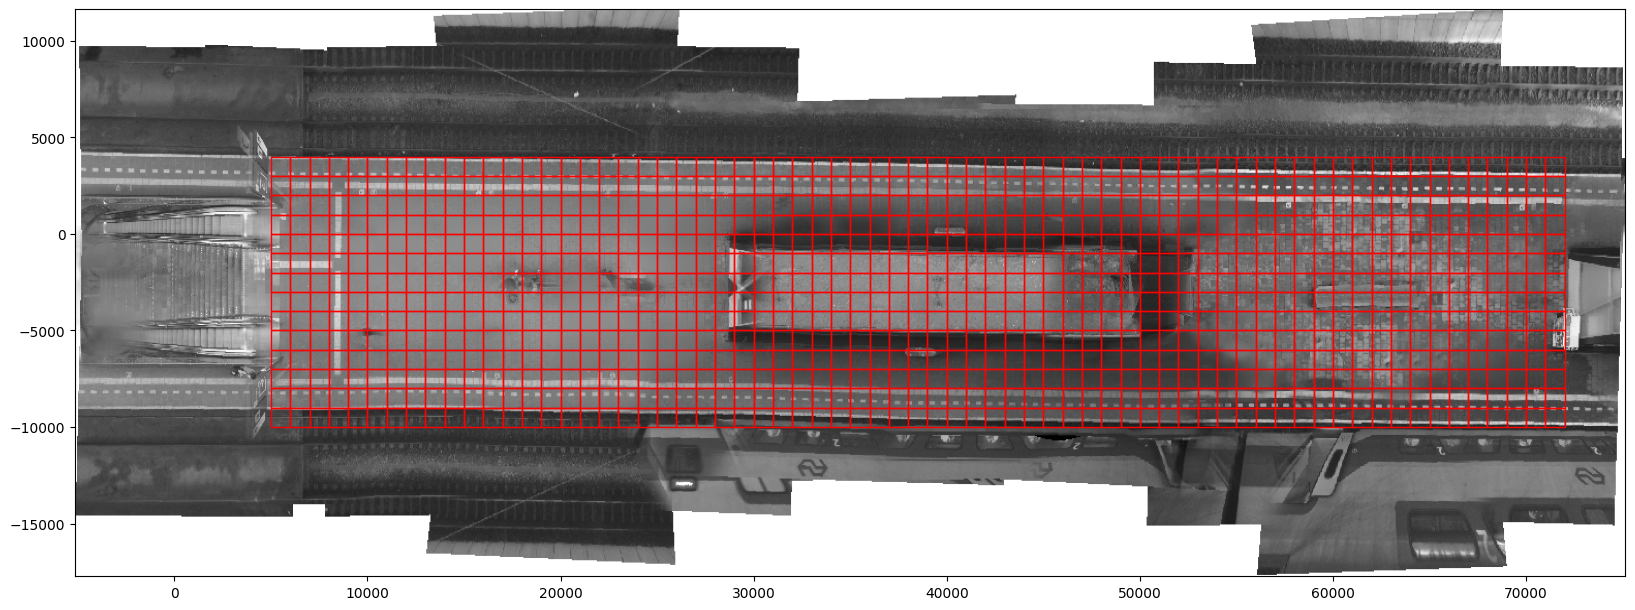

In [4]:
#GRID IS CREATED USING CONFIG
grid = create_grid(o, patch_size, total_patches, grid_angle)
#GRID IS PLOTTED ON STATION
plot_grid(grid, 'ehv')

# Get data and separate by direction and train presence

In [5]:
%%time
%%capture
data = getDay(20220314,'ehv')
data = data.drop(data[data.x_pos < o_x].index)
data = data.drop(data[data.y_pos < o_y].index)
data = data.drop(data[data.x_pos > (total_patches[0]-1)*patch_width].index)
data = data.drop(data[data.y_pos > (total_patches[1]-1)*patch_height].index)

CPU times: user 16 s, sys: 1.66 s, total: 17.7 s
Wall time: 20.9 s


In [6]:
data

,date_time_utc,tracked_object,y_pos,x_pos,datetime
0,2022-03-13 23:00:00.000,3351342,2720.0,18297.0,2022-03-14 00:00:00+01:00
1,2022-03-13 23:00:00.000,3351431,891.0,18726.0,2022-03-14 00:00:00+01:00
2,2022-03-13 23:00:00.000,3351436,1997.0,19123.0,2022-03-14 00:00:00+01:00
3,2022-03-13 23:00:00.000,3351437,-307.0,21528.0,2022-03-14 00:00:00+01:00
4,2022-03-13 23:00:00.000,3351440,-4132.0,11551.0,2022-03-14 00:00:00+01:00
...,...,...,...,...,...
21170955,2022-03-14 22:59:59.800,3393524,-3753.0,5364.0,2022-03-14 23:59:59.800000+01:00
21170956,2022-03-14 22:59:59.900,3393507,-3388.0,8773.0,2022-03-14 23:59:59.900000+01:00
21170957,2022-03-14 22:59:59.900,3393522,-1317.0,5434.0,2022-03-14 23:59:59.900000+01:00
21170958,2022-03-14 22:59:59.900,3393523,-4023.0,8686.0,2022-03-14 23:59:59.900000+01:00


In [7]:
%%time
%%capture
(data_on_array ,data_off) = data_division(data)
#data_on_array = [data_on_no_train, data_on_train_top, data_on_train_bottom, data_on_train_both]

CPU times: user 47.4 s, sys: 476 ms, total: 47.9 s
Wall time: 45.4 s


In [8]:
data_on_no_train = data_on_array[0]
data_on_train_top = data_on_array[1]
data_on_train_bottom = data_on_array[2]
data_on_train_both = data_on_array[3]

In [9]:
data_on_train_top

,date_time_utc,tracked_object,y_pos,x_pos,datetime,time
528086,2022-03-14 05:37:16.000,3351939,2071.0,15826.0,2022-03-14 06:37:16+01:00,1647236236
528087,2022-03-14 05:37:16.000,3351943,672.0,25590.0,2022-03-14 06:37:16+01:00,1647236236
528088,2022-03-14 05:37:16.000,3351945,440.0,65134.0,2022-03-14 06:37:16+01:00,1647236236
528089,2022-03-14 05:37:16.000,3351946,-895.0,7466.0,2022-03-14 06:37:16+01:00,1647236236
528090,2022-03-14 05:37:16.000,3351947,-879.0,7034.0,2022-03-14 06:37:16+01:00,1647236236
...,...,...,...,...,...,...
20904748,2022-03-14 21:05:43.700,3392670,-5822.0,32387.0,2022-03-14 22:05:43.700000+01:00,1647291943
20904764,2022-03-14 21:05:43.800,3392552,-4964.0,27450.0,2022-03-14 22:05:43.800000+01:00,1647291943
20904765,2022-03-14 21:05:43.800,3392670,-5794.0,32388.0,2022-03-14 22:05:43.800000+01:00,1647291943
20904780,2022-03-14 21:05:43.900,3392552,-4925.0,27457.0,2022-03-14 22:05:43.900000+01:00,1647291943


# Frequency calculation

Now that the data has been prepared, and divided into 5 different dataframes, the data will be processed, and one matrix will be created out of each dataframe.
For all of the observed day data so far, there are no moments where 2 trains are in the platform at the same time, so a matrix for this situation cannot be created. For that reason only the following matrices will be computed:
- Transition matrix for offboarding
- Transition matrix for onboarding without a train in the platform
- Transition matrix for onboarding with a train at the top of the platform
- Transition matrix for onboarding with a train at the bottom of the platform

The algorythm for the computation of the matrix should be the same for all 4 dataframe, so I will be using the offboarding data for development.

In [40]:
def zone(x_pos, y_pos):
    origin = o
    size = patch_size
    
    i = np.floor((x_pos-origin[0])/size[0])
    j = np.floor((y_pos-origin[1])/size[1])
    
    total_x_patches = total_patches[0]
    total_y_patches = total_patches[1]
    
    zone = (i*total_y_patches)+j
    return int(zone)

In [11]:
zone(115,-4500)

-65

In [12]:
#INITIALIZE MARKOV MATRIX TO APPROPIATE SIZE ALL 0s
markov_matrix = []
for i in range(abs_total_patches+1):
    markov_matrix.append([])
    for j in range(abs_total_patches+1):
        markov_matrix[i].append(0)

In [13]:
object_routes = {}
for x in (data_off.tracked_object.unique()):
    object_routes[x] = []

In [14]:
len(data_off.tracked_object.unique())

20340

In [15]:
data_off

,date_time_utc,tracked_object,y_pos,x_pos,datetime,time
0,2022-03-13 23:00:00.000,3351342,2720.0,18297.0,2022-03-14 00:00:00+01:00,1647212400
1,2022-03-13 23:00:00.000,3351431,891.0,18726.0,2022-03-14 00:00:00+01:00,1647212400
2,2022-03-13 23:00:00.000,3351436,1997.0,19123.0,2022-03-14 00:00:00+01:00,1647212400
3,2022-03-13 23:00:00.000,3351437,-307.0,21528.0,2022-03-14 00:00:00+01:00,1647212400
7,2022-03-13 23:00:00.100,3351342,2720.0,18297.0,2022-03-14 00:00:00.100000+01:00,1647212400
...,...,...,...,...,...,...
21170713,2022-03-14 22:59:53.000,3393521,-4212.0,8145.0,2022-03-14 23:59:53+01:00,1647298793
21170716,2022-03-14 22:59:53.100,3393521,-4211.0,8142.0,2022-03-14 23:59:53.100000+01:00,1647298793
21170719,2022-03-14 22:59:53.200,3393521,-4179.0,8143.0,2022-03-14 23:59:53.200000+01:00,1647298793
21170722,2022-03-14 22:59:53.300,3393521,-4145.0,8152.0,2022-03-14 23:59:53.300000+01:00,1647298793


In [16]:
%%time
sample_period = 1
all_object_routes = []
for x in object_routes:
    object_data = data_off[data_off['tracked_object'] == x].reset_index().drop('index', axis=1)
    for y in range(0, len(object_data)-1, sample_period*10):
        curr_patch = zone(object_data.x_pos[y],object_data.y_pos[y])
        object_routes[x].append(curr_patch)
    object_routes[x].append(-1)
    all_object_routes.extend(object_routes[x])

CPU times: user 3min 37s, sys: 2.53 s, total: 3min 39s
Wall time: 1min 25s


In [17]:
change_count = {}
zone_appearance_count = {}
for zone in range(len(all_object_routes)):
    curr_zone = all_object_routes[zone]
    
    if (zone+1 != len(all_object_routes)) and (curr_zone != -1):
        next_zone = all_object_routes[zone+1]
        
        if ((curr_zone,next_zone) in change_count):
            change_count[(curr_zone,next_zone)] += 1
        else:
            change_count[(curr_zone,next_zone)] = 1
        
        if (curr_zone in zone_appearance_count):
            zone_appearance_count[(curr_zone)] += 1
        else:
            zone_appearance_count[(curr_zone)] = 1


In [18]:
change_probabilities = {}
for zone_1, zone_2 in change_count:
    change_probabilities[(zone_1,zone_2)] = change_count[(zone_1,zone_2)]/zone_appearance_count[zone_1]
    markov_matrix[zone_1][zone_2] = change_probabilities[(zone_1,zone_2)]

In [30]:
name_and_path = 'results/offboarding/'+str(20220314)+'.csv'
with open(name_and_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(markov_matrix)

In [38]:
day_to_analyze = 20220314

In [43]:
def zone(x_pos, y_pos):
    origin = o
    size = patch_size
    
    i = np.floor((x_pos-origin[0])/size[0])
    j = np.floor((y_pos-origin[1])/size[1])
    
    total_x_patches = total_patches[0]
    total_y_patches = total_patches[1]
    
    zone = (i*total_y_patches)+j
    return int(zone)

print('Initializing markov matrix to appropiate size')
markov_matrix_on_no = []
for i in range(abs_total_patches+1):
    markov_matrix_on_no.append([])
    for j in range(abs_total_patches+1):
        markov_matrix_on_no[i].append(0)
print('Markov matrix initialized succesfully')

print('Initializing object routes dictionary')
object_routes_on_no = {}
for x in (data_on_no_train.tracked_object.unique()):
    object_routes_on_no[x] = []
print('Initialized succesfully')

print('Calculating pedestrian routes')
all_object_routes_on_no = []
for x in object_routes_on_no:
    object_data = data_on_no_train[data_on_no_train['tracked_object'] == x].reset_index().drop('index', axis=1)
    for y in range(0, len(object_data)-1, sample_period*10):
        curr_patch = zone(object_data.x_pos[y],object_data.y_pos[y])
        object_routes_on_no[x].append(curr_patch)
    object_routes_on_no[x].append(-1)
    all_object_routes_on_no.extend(object_routes_on_no[x])
print('Routes calculated')

print('Counting movements and transitions')
change_count_on_no = {}
zone_appearance_count_on_no = {}
for zone in range(len(all_object_routes_on_no)):
    curr_zone = all_object_routes_on_no[zone]
    
    if (zone+1 != len(all_object_routes_on_no)) and (curr_zone != -1):
        next_zone = all_object_routes_on_no[zone+1]
        
        if ((curr_zone,next_zone) in change_count_on_no):
            change_count_on_no[(curr_zone,next_zone)] += 1
        else:
            change_count_on_no[(curr_zone,next_zone)] = 1
        
        if (curr_zone in zone_appearance_count_on_no):
            zone_appearance_count_on_no[(curr_zone)] += 1
        else:
            zone_appearance_count_on_no[(curr_zone)] = 1
print('Counting finished succesfully')

print('Calculating frequencies')
change_probabilities_on_no = {}
for zone_1, zone_2 in change_count_on_no:
    change_probabilities_on_no[(zone_1,zone_2)] = change_count_on_no[(zone_1,zone_2)]/zone_appearance_count_on_no[zone_1]
    markov_matrix_on_no[zone_1][zone_2] = change_probabilities_on_no[(zone_1,zone_2)]
print('Frequencies succesfully calculated')

print('Exporting result to matrix')
result_name_and_path_on_no = 'results/onboarding_no_train/'+str(day_to_analyze)+'.csv'
with open(result_name_and_path_on_no, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(markov_matrix_on_no)
f.close()


Initializing markov matrix to appropiate size
Markov matrix initialized succesfully
Initializing object routes dictionary
Initialized succesfully
Calculating pedestrian routes
Routes calculated
Counting movements and transitions
Counting finished succesfully
Calculating frequencies
Frequencies succesfully calculated
Exporting result to matrix


In [46]:
def zone(x_pos, y_pos):
    origin = o
    size = patch_size
    
    i = np.floor((x_pos-origin[0])/size[0])
    j = np.floor((y_pos-origin[1])/size[1])
    
    total_x_patches = total_patches[0]
    total_y_patches = total_patches[1]
    
    zone = (i*total_y_patches)+j
    return int(zone)

print('Initializing markov matrix to appropiate size')
markov_matrix_on_top = []
for i in range(abs_total_patches+1):
    markov_matrix_on_top.append([])
    for j in range(abs_total_patches+1):
        markov_matrix_on_top[i].append(0)
print('Markov matrix initialized succesfully')

print('Initializing object routes dictionary')
object_routes_on_top = {}
for x in (data_on_train_top.tracked_object.unique()):
    object_routes_on_top[x] = []
print('Initialized succesfully')

print('Calculating pedestrian routes')
all_object_routes_on_top = []
for x in object_routes_on_top:
    object_data = data_on_train_top[data_on_train_top['tracked_object'] == x].reset_index().drop('index', axis=1)
    for y in range(0, len(object_data)-1, sample_period*10):
        curr_patch = zone(object_data.x_pos[y],object_data.y_pos[y])
        object_routes_on_top[x].append(curr_patch)
    object_routes_on_top[x].append(-1)
    all_object_routes_on_top.extend(object_routes_on_top[x])
print('Routes calculated')

print('Counting movements and transitions')
change_count_on_top = {}
zone_appearance_count_on_top = {}
for zone in range(len(all_object_routes_on_top)):
    curr_zone = all_object_routes_on_top[zone]
    
    if (zone+1 != len(all_object_routes_on_top)) and (curr_zone != -1):
        next_zone = all_object_routes_on_top[zone+1]
        
        if ((curr_zone,next_zone) in change_count_on_top):
            change_count_on_top[(curr_zone,next_zone)] += 1
        else:
            change_count_on_top[(curr_zone,next_zone)] = 1
        
        if (curr_zone in zone_appearance_count_on_top):
            zone_appearance_count_on_top[(curr_zone)] += 1
        else:
            zone_appearance_count_on_top[(curr_zone)] = 1
print('Counting finished succesfully')

print('Calculating frequencies')
change_probabilities_on_top = {}
for zone_1, zone_2 in change_count_on_top:
    change_probabilities_on_top[(zone_1,zone_2)] = change_count_on_top[(zone_1,zone_2)]/zone_appearance_count_on_top[zone_1]
    markov_matrix_on_top[zone_1][zone_2] = change_probabilities_on_top[(zone_1,zone_2)]
print('Frequencies succesfully calculated')

print('Exporting result to matrix')
result_name_and_path_on_top = 'results/onboarding_top/'+str(day_to_analyze)+'.csv'
with open(result_name_and_path_on_top, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(markov_matrix_on_top)
f.close()


Initializing markov matrix to appropiate size
Markov matrix initialized succesfully
Initializing object routes dictionary
Initialized succesfully
Calculating pedestrian routes
Routes calculated
Counting movements and transitions
Counting finished succesfully
Calculating frequencies
Frequencies succesfully calculated
Exporting result to matrix


In [47]:
def zone(x_pos, y_pos):
    origin = o
    size = patch_size
    
    i = np.floor((x_pos-origin[0])/size[0])
    j = np.floor((y_pos-origin[1])/size[1])
    
    total_x_patches = total_patches[0]
    total_y_patches = total_patches[1]
    
    zone = (i*total_y_patches)+j
    return int(zone)

print('Initializing markov matrix to appropiate size')
markov_matrix_on_bottom = []
for i in range(abs_total_patches+1):
    markov_matrix_on_bottom.append([])
    for j in range(abs_total_patches+1):
        markov_matrix_on_bottom[i].append(0)
print('Markov matrix initialized succesfully')

print('Initializing object routes dictionary')
object_routes_on_bottom = {}
for x in (data_on_train_bottom.tracked_object.unique()):
    object_routes_on_bottom[x] = []
print('Initialized succesfully')

print('Calculating pedestrian routes')
all_object_routes_on_bottom = []
for x in object_routes_on_bottom:
    object_data = data_on_train_bottom[data_on_train_bottom['tracked_object'] == x].reset_index().drop('index', axis=1)
    for y in range(0, len(object_data)-1, sample_period*10):
        curr_patch = zone(object_data.x_pos[y],object_data.y_pos[y])
        object_routes_on_bottom[x].append(curr_patch)
    object_routes_on_bottom[x].append(-1)
    all_object_routes_on_bottom.extend(object_routes_on_bottom[x])
print('Routes calculated')

print('Counting movements and transitions')
change_count_on_bottom = {}
zone_appearance_count_on_bottom = {}
for zone in range(len(all_object_routes_on_bottom)):
    curr_zone = all_object_routes_on_bottom[zone]
    
    if (zone+1 != len(all_object_routes_on_bottom)) and (curr_zone != -1):
        next_zone = all_object_routes_on_bottom[zone+1]
        
        if ((curr_zone,next_zone) in change_count_on_bottom):
            change_count_on_bottom[(curr_zone,next_zone)] += 1
        else:
            change_count_on_bottom[(curr_zone,next_zone)] = 1
        
        if (curr_zone in zone_appearance_count_on_bottom):
            zone_appearance_count_on_bottom[(curr_zone)] += 1
        else:
            zone_appearance_count_on_bottom[(curr_zone)] = 1
print('Counting finished succesfully')

print('Calculating frequencies')
change_probabilities_on_bottom = {}
for zone_1, zone_2 in change_count_on_bottom:
    change_probabilities_on_bottom[(zone_1,zone_2)] = change_count_on_bottom[(zone_1,zone_2)]/zone_appearance_count_on_bottom[zone_1]
    markov_matrix_on_bottom[zone_1][zone_2] = change_probabilities_on_bottom[(zone_1,zone_2)]
print('Frequencies succesfully calculated')

print('Exporting result to matrix')
result_name_and_path_on_bottom = 'results/onboarding_bottom/'+str(day_to_analyze)+'.csv'
with open(result_name_and_path_on_bottom, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(markov_matrix_on_bottom)
f.close()


Initializing markov matrix to appropiate size
Markov matrix initialized succesfully
Initializing object routes dictionary
Initialized succesfully
Calculating pedestrian routes
Routes calculated
Counting movements and transitions
Counting finished succesfully
Calculating frequencies
Frequencies succesfully calculated
Exporting result to matrix


In [48]:
def zone(x_pos, y_pos):
    origin = o
    size = patch_size
    
    i = np.floor((x_pos-origin[0])/size[0])
    j = np.floor((y_pos-origin[1])/size[1])
    
    total_x_patches = total_patches[0]
    total_y_patches = total_patches[1]
    
    zone = (i*total_y_patches)+j
    return int(zone)

print('Initializing markov matrix to appropiate size')
markov_matrix_on_both = []
for i in range(abs_total_patches+1):
    markov_matrix_on_both.append([])
    for j in range(abs_total_patches+1):
        markov_matrix_on_both[i].append(0)
print('Markov matrix initialized succesfully')

print('Initializing object routes dictionary')
object_routes_on_both = {}
for x in (data_on_train_both.tracked_object.unique()):
    object_routes_on_both[x] = []
print('Initialized succesfully')

print('Calculating pedestrian routes')
all_object_routes_on_both = []
for x in object_routes_on_both:
    object_data = data_on_train_both[data_on_train_both['tracked_object'] == x].reset_index().drop('index', axis=1)
    for y in range(0, len(object_data)-1, sample_period*10):
        curr_patch = zone(object_data.x_pos[y],object_data.y_pos[y])
        object_routes_on_both[x].append(curr_patch)
    object_routes_on_both[x].append(-1)
    all_object_routes_on_both.extend(object_routes_on_both[x])
print('Routes calculated')

print('Counting movements and transitions')
change_count_on_both = {}
zone_appearance_count_on_both = {}
for zone in range(len(all_object_routes_on_both)):
    curr_zone = all_object_routes_on_both[zone]
    
    if (zone+1 != len(all_object_routes_on_both)) and (curr_zone != -1):
        next_zone = all_object_routes_on_both[zone+1]
        
        if ((curr_zone,next_zone) in change_count_on_both):
            change_count_on_both[(curr_zone,next_zone)] += 1
        else:
            change_count_on_both[(curr_zone,next_zone)] = 1
        
        if (curr_zone in zone_appearance_count_on_both):
            zone_appearance_count_on_both[(curr_zone)] += 1
        else:
            zone_appearance_count_on_both[(curr_zone)] = 1
print('Counting finished succesfully')

print('Calculating frequencies')
change_probabilities_on_both = {}
for zone_1, zone_2 in change_count_on_both:
    change_probabilities_on_both[(zone_1,zone_2)] = change_count_on_both[(zone_1,zone_2)]/zone_appearance_count_on_both[zone_1]
    markov_matrix_on_both[zone_1][zone_2] = change_probabilities_on_both[(zone_1,zone_2)]
print('Frequencies succesfully calculated')

print('Exporting result to matrix')
result_name_and_path_on_both = 'results/onboarding_both/'+str(day_to_analyze)+'.csv'
with open(result_name_and_path_on_both, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(markov_matrix_on_both)
f.close()


Initializing markov matrix to appropiate size
Markov matrix initialized succesfully
Initializing object routes dictionary
Initialized succesfully
Calculating pedestrian routes
Routes calculated
Counting movements and transitions
Counting finished succesfully
Calculating frequencies
Frequencies succesfully calculated
Exporting result to matrix
